In [1]:
#########################################################################
## COMPROBAR GPU ASIGNADA EN COLABORATORY
#########################################################################
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 11 16:35:27 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   54C    P8    18W / 100W |     54MiB /  6144MiB |     42%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gymnasium

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install stable_baselines3

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#########################################################################
## LIBRERIAS NECESARIAS
#########################################################################
import tensorflow as tf
import gymnasium as gym
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
import torch
from sklearn.model_selection import train_test_split

import sys

import os
from stable_baselines3.common.vec_env import DummyVecEnv


2024-06-11 16:35:29.891110: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 16:35:29.910973: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 16:35:30.059454: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 16:35:30.060006: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 16:35:30.927941: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [5]:
############################################################################
## Variables globales (hiperparámetros)
###########################################################################
EPOCHS=1
BATCH_SIZE=16

EPISODES=10
EPISODES_EVALUATE_G=50

TOTAL_TIMESTEPS_PPO_GENERATOR=50000
LEARNING_RATE=0.001

In [6]:
# Definimos el entorno
env= gym.make('Acrobot-v1')

# Obtenemos el espacio de estados y acciones del entorno
ob_space=env.observation_space
ac_space=env.action_space

# Mostramos el número de acciones del entorno
print(env.action_space.n)
# Mostramos el número de observaciones del entorno
print(ob_space.shape[0])

3
6


# Discriminador

## Red neuronal del Discriminador

In [7]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a,s',r] reales o sintéticas, de longitud 2*ob_space.shape[0] + ac_space.n+1.
# Output: probabilidad de que la secuencia sea real, valor perteneciente al intervalo [0,1]
discriminator_net=keras.Sequential(
    [
        keras.Input(shape=(None, 2*ob_space.shape[0] + ac_space.n+1)),
        layers.Dense(units=5,activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=5,activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=5, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 5)           85        
                                                                 
 layer2 (Dense)              (None, None, 5)           30        
                                                                 
 layer3 (Dense)              (None, None, 5)           30        
                                                                 
 prob (Dense)                (None, None, 1)           6         
                                                                 
Total params: 151 (604.00 Byte)
Trainable params: 151 (604.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-06-11 16:35:33.812195: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-11 16:35:33.812218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-11 16:35:33.812222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: usuario-ASUS-TUF-Gaming-F15-FX507ZM-TUF507ZM
2024-06-11 16:35:33.812316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.147.5
2024-06-11 16:35:33.812328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.147.5
2024-06-11 16:35:33.812330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.147.5


## Función de pérdida del Discriminador

In [8]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r]
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))

    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))

    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)

    loss = loss_expert + loss_agent

    loss = -loss

    return loss


## Clase del Discriminador

In [9]:
#########################################################################################
# Clase DISCRIMINADOR
########################################################################################
class Discriminator:
    def __init__(self, env, discriminator_net, expert_s, expert_a, expert_s_prima, expert_r, agent_s, agent_a, agent_s_prima, agent_r):
        # -Red neuronal del Discriminador
        self.discriminator_net=discriminator_net

        # -Experto: [s,a,s',r]
        self.expert_s=expert_s
        self.expert_a=expert_a
        self.expert_s_prima=expert_s_prima
        self.expert_r= np.array(expert_r)


        expert_a_one_hot=tf.one_hot(self.expert_a,depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot+= tf.random.normal(tf.shape(expert_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        expert_s_a=tf.concat([self.expert_s,expert_a_one_hot],axis=1)
        expert_s_a_s=tf.concat([expert_s_a, self.expert_s_prima], axis=1)
        expert_r=self.expert_r.reshape(-1, 1)

        # expert_s_a_s_r=>secuencia experta=>[s,a,s',r]
        self.expert_s_a_s_r=tf.concat([expert_s_a_s, expert_r], axis=1)

        # -Agente:  [s,a,s',r]
        self.agent_s=agent_s
        self.agent_a=agent_a
        self.agent_s_prima=agent_s_prima
        self.agent_r=np.array(agent_r)

        agent_a_one_hot=tf.one_hot(self.agent_a,depth=env.action_space.n)
        agent_a_one_hot+= tf.random.normal(tf.shape(agent_a_one_hot), mean=0.2, stddev=0.1, dtype=tf.float32)/1.2
        agent_s_a=tf.concat([self.agent_s,agent_a_one_hot],axis=1)
        agent_s_a_s=tf.concat([agent_s_a, self.agent_s_prima], axis=1)
        agent_r=self.agent_r.reshape(-1, 1)

        # agent_s_a_s_r=>secuencia agente=>[s,a,s',r]
        self.agent_s_a_s_r=tf.concat([agent_s_a_s, agent_r], axis=1)

        # Calculamos la salida de la red para [s,a,s',r] del experto y del agente ya que lo necesitamos para reward

        # -Salida de la red neuronal Discriminador para [s,a,s',r] expertos(verdaderos)
        self.prob_expert=self.discriminator_net(self.expert_s_a_s_r)

        # -Salida  de la red neuronal Discrimiinador para [s,a,s',r] Agente(falsos)
        self.prob_agent=self.discriminator_net(self.agent_s_a_s_r)

        #-Recompensa obtenida cuando el Agente realiza [s,a,s',r] falsas
        self.rewards=tf.math.log(tf.clip_by_value(self.prob_agent,1e-10,1)) 

    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a

    def getExpert_S_A(self):
        return self.expert_s_a

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards


# Generador

## Redes neuronales del Generador

In [10]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 6, s=[s1,s2,s3,s4,s5,s6]
# Output: acciones, listas de tamaño 3, a=[a1,a2,a3]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=5, activation=tf.tanh,name='layer1'),
        layers.Dense(units=5, activation=tf.tanh, name='layer2'),
        layers.Dense(units=3, activation=tf.tanh, name='layer3'),
        layers.Dense(units=3, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 5)           35        
                                                                 
 layer2 (Dense)              (None, None, 5)           30        
                                                                 
 layer3 (Dense)              (None, None, 3)           18        
                                                                 
 layer4 (Dense)              (None, None, 3)           12        
                                                                 
Total params: 95 (380.00 Byte)
Trainable params: 95 (380.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#############################################################################################################
# Red neuronal del Generador donde se producen v_pred
#############################################################################################################

# Input: estados, listas de tamaño 6, s=[s1,s2,s3,s4,s5,s6]
# Output: v_pred, listas de tamaño 1, v_pred

generator_net_v_preds=keras.Sequential(
    [
            keras.Input(shape=(None,ob_space.shape[0])),
            layers.Dense(units=5, activation=tf.tanh,name='layer1'),
            layers.Dense(units=5, activation=tf.tanh, name='layer2'),
            layers.Dense(units=1, activation=None, name='layer3'),
        ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()



Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 5)           35        
                                                                 
 layer2 (Dense)              (None, None, 5)           30        
                                                                 
 layer3 (Dense)              (None, None, 1)           6         
                                                                 
Total params: 71 (284.00 Byte)
Trainable params: 71 (284.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Generador

In [12]:
##################################################################################################################
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated"
#################################################################################################################
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)

    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del Generador

In [13]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator
class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env=env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal
        self.model=PPO(policy="MlpPolicy", env=env, verbose=0)


        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs=np.reshape(np.array(obs),(1,ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs =generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)



    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    # Devuelve los parámetros \theta de la política \pi
    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a,s',r] sinteticos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0


        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            next_observations=[]

            run_policy_steps = 0

            truncated=False
            terminated=False


            # La primera acción de cada episodio se crea con la red neuronal
            obs,_=env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=obs)

            act, v_pred = Old_Policy.act(stochastic=True)

            # Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act=act.numpy()

            elif isinstance(act, np.ndarray):
                act=act


            action=int(act)

            next_obs,reward,terminated,truncated, info=env.step(action)


            truncated=False
            terminated=False
            
            # Tenemos una política entrenada
            Policy = Policy_net('policy',env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated!= True and truncated!= True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_0,s_1,s_2,s_3]] por eso su tamaño es (1,4)
                observations.append(next_obs)  # S_i-1

                action, states_oc = Policy.get_model().predict(next_obs)

                action=int(action)

                # --Muevo al Agente al siguiente estado
                next_obs,reward,terminated,truncated,info=env.step(action)

                # --Actualización de variables
                actions.append(action) # A_i-1
                rewards.append(reward) # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated== True or truncated==True:
                    next_observations.append(next_obs)  # S_i
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    next_observations.append(next_obs)  # S_i
                    self.obs = next_obs


        observations = np.reshape(observations, newshape=[-1] + list(ob_space.shape))
        next_observations = np.reshape(next_observations, newshape=[-1] + list(ob_space.shape))
        actions = np.array(actions).astype(dtype=np.int32)


        # Devolvemos la secuencia (S,A,S',R) junto con la política anterior y la actual política,
        return observations, actions, next_observations, rewards, Old_Policy, Policy

In [14]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN

class PPOTrain:

    def __init__(self, Policy, Old_Policy, obs, actions, rewards, gamma=0.95, clip_value=0.2, c_1=1, c_2=0.01):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs=obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()


        policy_name = "policy"
        old_policy_name="policy"

        policy_dict_ = self.pi_trainable[policy_name]
        old_policy_dict_=self.old_pi_trainable[old_policy_name]

        self.pi=[]
        if policy_name in self.pi_trainable and old_policy_name in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy en policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print(f"No se encontró la política con el nombre: {policy_name}")


        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable
        self.actions = actions
        self.rewards=rewards
        self.v_preds=self.Old_Policy.get_v_preds()
        self.v_preds_next=self.Policy.get_v_preds()

        #  generative advantage estimator(lambda = 1), ver ppo paper eq(11)
        self.gaes =self.get_gaes(self.rewards, self.v_preds, self.v_preds_next)

        act_probs =self.Policy.get_action_prob()
        act_probs_old =self.Old_Policy.get_action_prob()

        # la probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # la probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss=loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma * v_next - v for r_t, v_next, v in zip(rewards, v_preds_next, v_preds)]
        # calcular la estimación generative advantage (lambda = 1), ver ppo paper eq(11)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) - 1)):  # # es T-1, donde T es time step con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes



# Extended GAIL

In [15]:
####################################################################################################################
# CLASE GAIL
####################################################################################################################
class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator=generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self,d_optimizer, loss_fn_D ):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D=  loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric,self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
        len_real = X_test.shape[0]

        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        dataset_gen1=np.concatenate([generate_observations,generate_a_one_hot],axis=1)

        dataset_gen2= np.concatenate([dataset_gen1,generate_next_observations], axis=1)

        rewards=np.array(rewards).reshape(-1, 1)

        dataset_gen= np.concatenate([dataset_gen2,rewards], axis=1)


        len_fakes=dataset_gen.shape[0]

        # Compilamos el discriminador como CNN
        self.discriminator.discriminator_net.compile(optimizer=self.d_optimizer, loss=self.loss_fn_D, metrics=['accuracy'])

        # Evaluamos como CNN
        loss_real, acc_real=self.discriminator.discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake=self.discriminator.discriminator_net.evaluate(dataset_gen,tf.ones((len_fakes,1)), batch_size=len_fakes, verbose=1)

        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)


    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env= gym.make('Acrobot-v1')

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa
        rewards=[]

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final
        # siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated=False
            terminated=False
            R=0.0
            reward=0.0

            # Estado inicial del juego
            obs,_=env.reset()

            #Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated!= True and truncated!=True:
                action, _=self.generator.get_model().predict(obs)
                obs,reward,terminated,truncated, info=env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R+=reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode,R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices,rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):

        # 1) Generamos secuencias falsas [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy=self.generator.generate_fakes()

        generate_a_one_hot=np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
          generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
          dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

        if generate_next_observations.shape[0] == generate_a_one_hot.shape[0]:
          dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations], axis=1)
        else:
           generate_next_observations_new= np.resize(generate_next_observations, generate_observations.shape)
           dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations_new], axis=1)

        rewards=np.array(rewards).reshape(-1,1)

        dataset_gen=np.concatenate([dataset_gen2, rewards], axis=1)

        # 2) Seleccionamos la muestra de datos generador con la que vamos a trabajar en este  batch de entrenamiento 
        #if len(dataset_gen) >= BATCH_SIZE: 
        random_indices = np.random.choice(len(dataset_gen), size=min(BATCH_SIZE,len(dataset_gen)), replace=False)
        dataset_gen= dataset_gen[random_indices[0]]

        # 3) Obtenemos las secuencias reales [s,a,s',r] de los datos de entrenamiento y las combinamos
        dataset_gen=dataset_gen.reshape(1,-1) 
        combined_images = tf.concat([X_train, dataset_gen], axis=0)

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat( [tf.ones((BATCH_SIZE, 1)), tf.zeros((BATCH_SIZE, 1))], axis=0 )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR
        #############################################################################################################################################################


        # Entrenamiento del discriminador con las [s,a, s', r] del agente(falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto secuencias reales como secuencias sintéticas
        with tf.GradientTape() as tape:
            predictions=np.zeros((2*BATCH_SIZE,6))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)

        self.d_optimizer.apply_gradients(
          zip(grads, self.discriminator.getNet().trainable_weights)
        )



        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA
        ###############################################################################################################################################################


        ppotrain=PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards, obs=generate_observations)  


        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()


        g_loss = tf.cast(g_loss, dtype=tf.float32)

        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        print("\n")
        print("\nd_loss=",d_loss.numpy())
        print("\ng_loss=",g_loss.numpy())

        return {"d_loss": self.d_loss_metric.result(),
                    "g_loss": self.g_loss_metric.result()}



# Experimentación de Extended GAIL con Acrobot

## Experimento 1

In [16]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [17]:
longitud_trayectoria = np.count_nonzero(expert_num_tray == 0)
print(longitud_trayectoria)

75


In [18]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [19]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [20]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 60
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 15


In [21]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

/home/usuario/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


### Definición de GAIL

In [22]:
gan1=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [23]:
tf.config.run_functions_eagerly(True)
gan1.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [24]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan1.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)



/home/usuario/.local/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(





d_loss= 2.0878

g_loss= 1.2713432
1/4 [======>.......................] - ETA: 29:08 - d_loss: 2.0878 - g_loss: 1.2713


d_loss= 2.0635417

g_loss= 1.2077018
2/4 [==============>...............] - ETA: 18:32 - d_loss: 2.0757 - g_loss: 1.2395


d_loss= 2.0782633

g_loss= 1.0681126
3/4 [=====================>........] - ETA: 9:14 - d_loss: 2.0765 - g_loss: 1.1824 


d_loss= 2.0374763

g_loss= 1.1909376
4/4 [==============================] - 2234s 551s/step - d_loss: 2.0668 - g_loss: 1.1845


### Evaluación de GAIL

In [25]:
# Evaluamos el Discriminador de GAIL en el TEST
gan1.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.0067 - accuracy: 0.0000e+00
>Loss real: 
0.12504008412361145
>Loss fake: 
0.00666885357350111


Episode  0 Total reward: -64.0
Episode  1 Total reward: -137.0
Episode  2 Total reward: -78.0
Episode  3 Total reward: -79.0
Episode  4 Total reward: -90.0
Episode  5 Total reward: -71.0
Episode  6 Total reward: -89.0
Episode  7 Total reward: -90.0
Episode  8 Total reward: -80.0
Episode  9 Total reward: -114.0
Episode  10 Total reward: -83.0
Episode  11 Total reward: -95.0
Episode  12 Total reward: -78.0
Episode  13 Total reward: -80.0
Episode  14 Total reward: -120.0
Episode  15 Total reward: -138.0
Episode  16 Total reward: -69.0
Episode  17 Total reward: -94.0
Episode  18 Total reward: -67.0
Episode  19 Total reward: -94.0
Episode  20 Total reward: -92.0
Episode  21 Total reward: -82.0
Episode  22 Total reward: -71.0
Episode  23 Total reward: -71.0
Episode  24 Total reward: -80.0
Episode  25 Total reward: -69.0
Episode  26 Total reward: -92.0
Episode  27 Total reward: -89.0
Episode  28 Total reward: -72.0
Episode  29 Total reward: -98.0
Episode  30 Total reward: -63.0
Episode  31 To

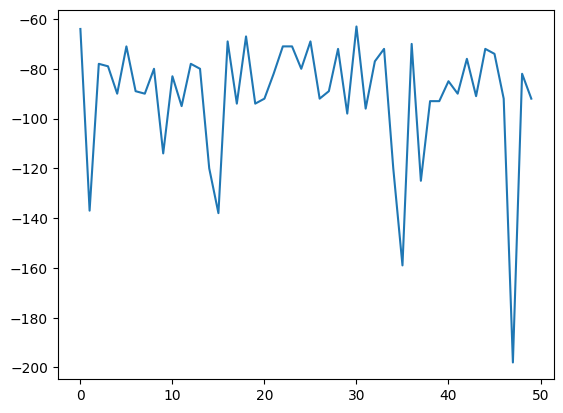


Recompensa de Media: -90.92 



In [26]:
# Evaluamos al Generador 
rewardMean=gan1.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 2 

In [27]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [28]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 1)
print(longitud_trayectoria)

222


In [29]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [30]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [31]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 177
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 45


In [32]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [33]:
gan2=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [34]:
tf.config.run_functions_eagerly(True)
gan2.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [35]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan2.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)




d_loss= 1.8697467

g_loss= 1.0447142
 1/12 [=>............................] - ETA: 1:40:25 - d_loss: 1.8697 - g_loss: 1.0447


d_loss= 1.8762841

g_loss= 1.4287927
 2/12 [====>.........................] - ETA: 1:34:34 - d_loss: 1.8730 - g_loss: 1.2368


d_loss= 1.9709433

g_loss= 1.4276696
 3/12 [======>.......................] - ETA: 1:23:56 - d_loss: 1.9057 - g_loss: 1.3004


d_loss= 1.8956904

g_loss= 0.7058212
 4/12 [=========>....................] - ETA: 1:14:38 - d_loss: 1.9032 - g_loss: 1.1517


d_loss= 2.0766835

g_loss= -0.26165223
 5/12 [===========>..................] - ETA: 1:04:53 - d_loss: 1.9379 - g_loss: 0.8691


d_loss= 2.008912

g_loss= 1.1981269
 6/12 [==============>...............] - ETA: 55:24 - d_loss: 1.9497 - g_loss: 0.9239  


d_loss= 2.0212572

g_loss= 1.044389
 7/12 [================>.............] - ETA: 46:05 - d_loss: 1.9599 - g_loss: 0.9411


d_loss= 1.904187

g_loss= 0.88088334
 8/12 [===================>..........] - ETA: 37:01 - d_loss: 1.9530 - g_

### Evaluación de GAIL

In [36]:
# Evaluamos el Discriminador de GAIL en el TEST
gan2.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.0834 - accuracy: 0.0000e+00
>Loss real: 
0.11129608005285263
>Loss fake: 
0.08341872692108154


Episode  0 Total reward: -90.0
Episode  1 Total reward: -116.0
Episode  2 Total reward: -71.0
Episode  3 Total reward: -80.0
Episode  4 Total reward: -123.0
Episode  5 Total reward: -84.0
Episode  6 Total reward: -80.0
Episode  7 Total reward: -89.0
Episode  8 Total reward: -85.0
Episode  9 Total reward: -110.0
Episode  10 Total reward: -94.0
Episode  11 Total reward: -70.0
Episode  12 Total reward: -74.0
Episode  13 Total reward: -91.0
Episode  14 Total reward: -71.0
Episode  15 Total reward: -83.0
Episode  16 Total reward: -75.0
Episode  17 Total reward: -124.0
Episode  18 Total reward: -92.0
Episode  19 Total reward: -60.0
Episode  20 Total reward: -93.0
Episode  21 Total reward: -81.0
Episode  22 Total reward: -121.0
Episode  23 Total reward: -98.0
Episode  24 Total reward: -82.0
Episode  25 Total reward: -69.0
Episode  26 Total reward: -92.0
Episode  27 Total reward: -97.0
Episode  28 Total reward: -64.0
Episode  29 Total reward: -75.0
Episode  30 Total reward: -105.0
Episode  31 

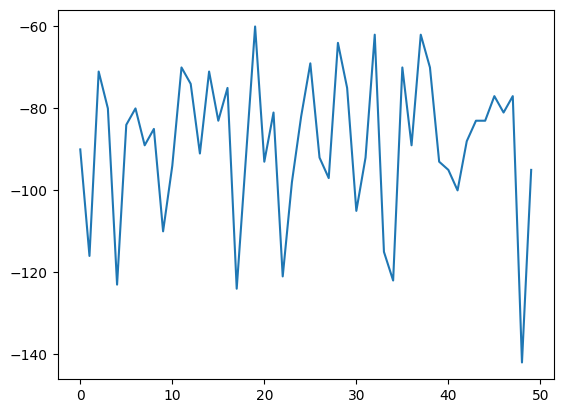


Recompensa de Media: -88.7 



In [37]:
# Evaluamos al Generador 
rewardMean=gan2.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 3

In [38]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [39]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 2)
print(longitud_trayectoria)

303


In [40]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [41]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [42]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 242
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 61


In [43]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [44]:
gan3=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [45]:
tf.config.run_functions_eagerly(True)
gan3.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [46]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan3.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.9253591

g_loss= 1.0251288
 1/16 [>.............................] - ETA: 2:12:42 - d_loss: 1.9254 - g_loss: 1.0251


d_loss= 2.041172

g_loss= 1.0146145
 2/16 [==>...........................] - ETA: 2:06:48 - d_loss: 1.9833 - g_loss: 1.0199


d_loss= 2.0429497

g_loss= 0.8144669
 3/16 [====>.........................] - ETA: 1:56:27 - d_loss: 2.0032 - g_loss: 0.9514


d_loss= 1.8878134

g_loss= 0.65381473
 4/16 [======>.......................] - ETA: 1:47:02 - d_loss: 1.9743 - g_loss: 0.8770


d_loss= 2.0034018

g_loss= 0.33362255
 5/16 [========>.....................] - ETA: 1:38:05 - d_loss: 1.9801 - g_loss: 0.7683


d_loss= 1.9707628

g_loss= 1.1458594
 6/16 [==========>...................] - ETA: 1:29:14 - d_loss: 1.9786 - g_loss: 0.8313


d_loss= 1.8460535

g_loss= 0.90934783
 7/16 [============>.................] - ETA: 1:20:44 - d_loss: 1.9596 - g_loss: 0.8424


d_loss= 2.0020244

g_loss= 1.143175
 8/16 [==============>...............] - ETA: 1:11:45 - d_loss: 1.9649

### Evaluación de GAIL

In [47]:
# Evaluamos el Discriminador de GAIL en el TEST
gan3.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.0600 - accuracy: 0.0000e+00
>Loss real: 
0.06554620712995529
>Loss fake: 
0.059990447014570236


Episode  0 Total reward: -80.0
Episode  1 Total reward: -93.0
Episode  2 Total reward: -85.0
Episode  3 Total reward: -62.0
Episode  4 Total reward: -95.0
Episode  5 Total reward: -92.0
Episode  6 Total reward: -88.0
Episode  7 Total reward: -82.0
Episode  8 Total reward: -106.0
Episode  9 Total reward: -77.0
Episode  10 Total reward: -82.0
Episode  11 Total reward: -75.0
Episode  12 Total reward: -98.0
Episode  13 Total reward: -97.0
Episode  14 Total reward: -78.0
Episode  15 Total reward: -63.0
Episode  16 Total reward: -82.0
Episode  17 Total reward: -75.0
Episode  18 Total reward: -92.0
Episode  19 Total reward: -89.0
Episode  20 Total reward: -87.0
Episode  21 Total reward: -94.0
Episode  22 Total reward: -78.0
Episode  23 Total reward: -115.0
Episode  24 Total reward: -86.0
Episode  25 Total reward: -63.0
Episode  26 Total reward: -108.0
Episode  27 Total reward: -86.0
Episode  28 Total reward: -83.0
Episode  29 Total reward: -94.0
Episode  30 Total reward: -80.0
Episode  31 Tot

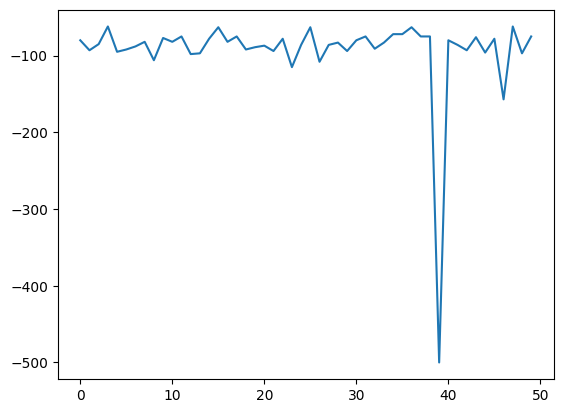


Recompensa de Media: -93.42 



In [48]:
# Evaluamos al Generador 
rewardMean=gan3.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 4

In [49]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [50]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 3)
print(longitud_trayectoria)

377


In [51]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [52]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [53]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 301
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 76


In [54]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [55]:
gan4=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [56]:
tf.config.run_functions_eagerly(True)
gan4.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [57]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan4.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 2.0304973

g_loss= 0.7470668
 1/19 [>.............................] - ETA: 2:39:25 - d_loss: 2.0305 - g_loss: 0.7471


d_loss= 1.8662642

g_loss= 1.4028336
 2/19 [==>...........................] - ETA: 2:25:34 - d_loss: 1.9484 - g_loss: 1.0750


d_loss= 1.9432324

g_loss= 1.3154681
 3/19 [===>..........................] - ETA: 2:16:05 - d_loss: 1.9467 - g_loss: 1.1551


d_loss= 1.9614567

g_loss= 0.26682135
 4/19 [=====>........................] - ETA: 2:08:16 - d_loss: 1.9504 - g_loss: 0.9330


d_loss= 1.9474694

g_loss= 1.000763
 5/19 [======>.......................] - ETA: 2:01:13 - d_loss: 1.9498 - g_loss: 0.9466


d_loss= 1.9975604

g_loss= 1.2222123
 6/19 [========>.....................] - ETA: 1:52:26 - d_loss: 1.9577 - g_loss: 0.9925


d_loss= 1.9519843

g_loss= 0.7950936
 7/19 [==========>...................] - ETA: 1:44:00 - d_loss: 1.9569 - g_loss: 0.9643


d_loss= 1.9847463

g_loss= 1.440334
 8/19 [===========>..................] - ETA: 1:35:16 - d_loss: 1.9604 -

### Evaluación de GAIL

In [58]:
# Evaluamos el Discriminador de GAIL en el TEST
gan4.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.0447 - accuracy: 0.0000e+00
>Loss real: 
0.039719611406326294
>Loss fake: 
0.04470148682594299


Episode  0 Total reward: -105.0
Episode  1 Total reward: -86.0
Episode  2 Total reward: -70.0
Episode  3 Total reward: -84.0
Episode  4 Total reward: -63.0
Episode  5 Total reward: -64.0
Episode  6 Total reward: -73.0
Episode  7 Total reward: -179.0
Episode  8 Total reward: -79.0
Episode  9 Total reward: -92.0
Episode  10 Total reward: -97.0
Episode  11 Total reward: -100.0
Episode  12 Total reward: -97.0
Episode  13 Total reward: -64.0
Episode  14 Total reward: -96.0
Episode  15 Total reward: -105.0
Episode  16 Total reward: -85.0
Episode  17 Total reward: -72.0
Episode  18 Total reward: -84.0
Episode  19 Total reward: -65.0
Episode  20 Total reward: -84.0
Episode  21 Total reward: -74.0
Episode  22 Total reward: -98.0
Episode  23 Total reward: -189.0
Episode  24 Total reward: -63.0
Episode  25 Total reward: -79.0
Episode  26 Total reward: -68.0
Episode  27 Total reward: -73.0
Episode  28 Total reward: -89.0
Episode  29 Total reward: -134.0
Episode  30 Total reward: -78.0
Episode  31 

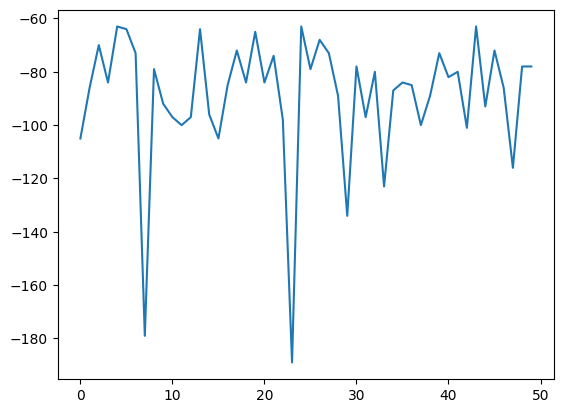


Recompensa de Media: -89.12 



In [59]:
# Evaluamos al Generador 
rewardMean=gan4.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 5

In [60]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [61]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 4)
print(longitud_trayectoria)

460


In [62]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [63]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [64]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 368
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 92


In [65]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [66]:
gan5=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [67]:
tf.config.run_functions_eagerly(True)
gan5.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [68]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan5.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.8415736

g_loss= 0.7437691
 1/23 [>.............................] - ETA: 3:09:34 - d_loss: 1.8416 - g_loss: 0.7438


d_loss= 1.9312676

g_loss= 0.5493609
 2/23 [=>............................] - ETA: 2:58:29 - d_loss: 1.8864 - g_loss: 0.6466


d_loss= 1.9781045

g_loss= 0.859627
 3/23 [==>...........................] - ETA: 2:49:46 - d_loss: 1.9170 - g_loss: 0.7176


d_loss= 2.0555816

g_loss= 0.73731816
 4/23 [====>.........................] - ETA: 2:45:16 - d_loss: 1.9516 - g_loss: 0.7225


d_loss= 2.0261133

g_loss= 1.2884364
 5/23 [=====>........................] - ETA: 2:35:46 - d_loss: 1.9665 - g_loss: 0.8357


d_loss= 1.9288523

g_loss= 1.09913
 6/23 [======>.......................] - ETA: 2:27:04 - d_loss: 1.9602 - g_loss: 0.8796


d_loss= 1.9196136

g_loss= 1.4146641
 7/23 [========>.....................] - ETA: 2:18:34 - d_loss: 1.9544 - g_loss: 0.9560


d_loss= 1.9952565

g_loss= 0.50107294
 8/23 [=========>....................] - ETA: 2:09:42 - d_loss: 1.9595 -

### Evaluación de GAIL

In [69]:
# Evaluamos el Discriminador de GAIL en el TEST
gan5.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.0369 - accuracy: 0.0000e+00
>Loss real: 
0.030639316886663437
>Loss fake: 
0.0369291827082634


Episode  0 Total reward: -84.0
Episode  1 Total reward: -137.0
Episode  2 Total reward: -75.0
Episode  3 Total reward: -78.0
Episode  4 Total reward: -99.0
Episode  5 Total reward: -70.0
Episode  6 Total reward: -73.0
Episode  7 Total reward: -143.0
Episode  8 Total reward: -143.0
Episode  9 Total reward: -108.0
Episode  10 Total reward: -99.0
Episode  11 Total reward: -124.0
Episode  12 Total reward: -125.0
Episode  13 Total reward: -75.0
Episode  14 Total reward: -83.0
Episode  15 Total reward: -87.0
Episode  16 Total reward: -79.0
Episode  17 Total reward: -107.0
Episode  18 Total reward: -111.0
Episode  19 Total reward: -72.0
Episode  20 Total reward: -87.0
Episode  21 Total reward: -75.0
Episode  22 Total reward: -129.0
Episode  23 Total reward: -108.0
Episode  24 Total reward: -97.0
Episode  25 Total reward: -72.0
Episode  26 Total reward: -97.0
Episode  27 Total reward: -94.0
Episode  28 Total reward: -94.0
Episode  29 Total reward: -106.0
Episode  30 Total reward: -83.0
Episode

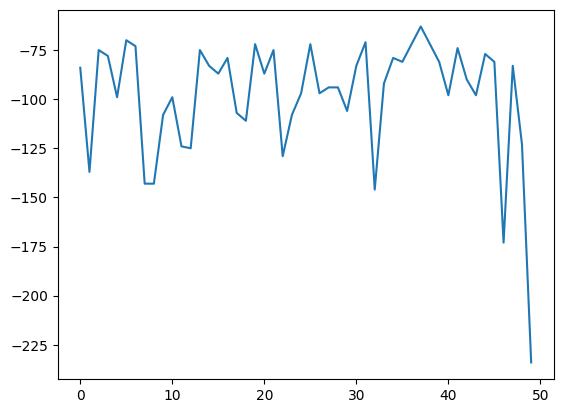


Recompensa de Media: -98.04 



In [70]:
# Evaluamos al Generador 
rewardMean=gan5.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 6

In [71]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [72]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 5)
print(longitud_trayectoria)

547


In [73]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [74]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [75]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 437
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 110


In [76]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [77]:
gan6=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [78]:
tf.config.run_functions_eagerly(True)
gan6.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [79]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan6.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.8167301

g_loss= 0.96586645
 1/28 [>.............................] - ETA: 3:57:25 - d_loss: 1.8167 - g_loss: 0.9659


d_loss= 2.0604086

g_loss= 1.3110317
 2/28 [=>............................] - ETA: 3:48:06 - d_loss: 1.9386 - g_loss: 1.1384


d_loss= 1.9062407

g_loss= 1.2837571
 3/28 [==>...........................] - ETA: 3:42:19 - d_loss: 1.9278 - g_loss: 1.1869


d_loss= 1.860226

g_loss= 1.1295356
 4/28 [===>..........................] - ETA: 3:35:44 - d_loss: 1.9109 - g_loss: 1.1725


d_loss= 1.9313726

g_loss= 0.7181388
 5/28 [====>.........................] - ETA: 3:26:12 - d_loss: 1.9150 - g_loss: 1.0817


d_loss= 1.7982787

g_loss= 1.1031928
 6/28 [=====>........................] - ETA: 3:17:13 - d_loss: 1.8955 - g_loss: 1.0853


d_loss= 1.920053

g_loss= 1.203587
 7/28 [======>.......................] - ETA: 3:07:36 - d_loss: 1.8990 - g_loss: 1.1022


d_loss= 1.9462315

g_loss= 1.296445
 8/28 [=======>......................] - ETA: 2:58:24 - d_loss: 1.9049 - g

### Evaluación de GAIL

In [80]:
# Evaluamos el Discriminador de GAIL en el TEST
gan6.evaluate_D(X_test)


1/1 [==============================] - 0s 17ms/step - loss: 0.0197 - accuracy: 0.0000e+00
>Loss real: 
0.011239605955779552
>Loss fake: 
0.019665949046611786


Episode  0 Total reward: -93.0
Episode  1 Total reward: -78.0
Episode  2 Total reward: -157.0
Episode  3 Total reward: -96.0
Episode  4 Total reward: -72.0
Episode  5 Total reward: -70.0
Episode  6 Total reward: -77.0
Episode  7 Total reward: -74.0
Episode  8 Total reward: -89.0
Episode  9 Total reward: -65.0
Episode  10 Total reward: -223.0
Episode  11 Total reward: -92.0
Episode  12 Total reward: -95.0
Episode  13 Total reward: -69.0
Episode  14 Total reward: -76.0
Episode  15 Total reward: -90.0
Episode  16 Total reward: -84.0
Episode  17 Total reward: -91.0
Episode  18 Total reward: -72.0
Episode  19 Total reward: -61.0
Episode  20 Total reward: -97.0
Episode  21 Total reward: -97.0
Episode  22 Total reward: -82.0
Episode  23 Total reward: -71.0
Episode  24 Total reward: -89.0
Episode  25 Total reward: -71.0
Episode  26 Total reward: -91.0
Episode  27 Total reward: -84.0
Episode  28 Total reward: -66.0
Episode  29 Total reward: -83.0
Episode  30 Total reward: -120.0
Episode  31 Tot

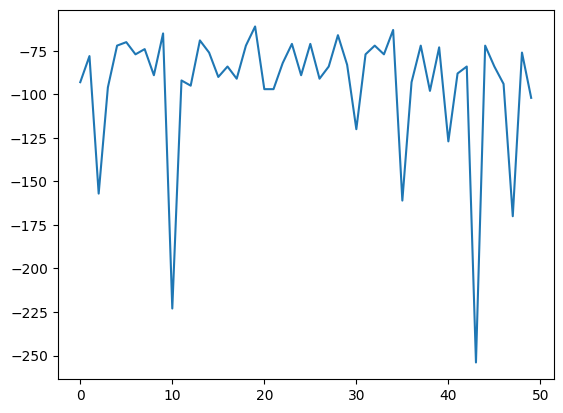


Recompensa de Media: -94.24 



In [81]:
# Evaluamos al Generador 
rewardMean=gan6.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 7

In [82]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [83]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 6)
print(longitud_trayectoria)

634


In [84]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [85]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [86]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 507
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 127


In [87]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [88]:
gan7=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [89]:
tf.config.run_functions_eagerly(True)
gan7.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [90]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan7.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.9329798

g_loss= 0.49003932
 1/32 [..............................] - ETA: 5:02:33 - d_loss: 1.9330 - g_loss: 0.4900


d_loss= 1.8160286

g_loss= 0.8575468
 2/32 [>.............................] - ETA: 4:56:48 - d_loss: 1.8745 - g_loss: 0.6738


d_loss= 2.0178518

g_loss= 1.0102687
 3/32 [=>............................] - ETA: 4:40:00 - d_loss: 1.9223 - g_loss: 0.7860


d_loss= 2.0117447

g_loss= 0.74108803
 4/32 [==>...........................] - ETA: 4:32:01 - d_loss: 1.9447 - g_loss: 0.7747


d_loss= 1.9709872

g_loss= 0.41961718
 5/32 [===>..........................] - ETA: 4:25:30 - d_loss: 1.9499 - g_loss: 0.7037


d_loss= 1.8532197

g_loss= 1.1104132
 6/32 [====>.........................] - ETA: 4:15:21 - d_loss: 1.9338 - g_loss: 0.7715


d_loss= 1.9744802

g_loss= 1.2387897
 7/32 [=====>........................] - ETA: 4:04:40 - d_loss: 1.9396 - g_loss: 0.8383


d_loss= 2.0089355

g_loss= 0.9263823
 8/32 [======>.......................] - ETA: 3:52:52 - d_loss: 1.94

### Evaluación de GAIL

In [91]:
# Evaluamos el Discriminador de GAIL en el TEST
gan7.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 0.0023 - accuracy: 0.0000e+00
>Loss real: 
0.00475300382822752
>Loss fake: 
0.002314611803740263


Episode  0 Total reward: -89.0
Episode  1 Total reward: -77.0
Episode  2 Total reward: -70.0
Episode  3 Total reward: -71.0
Episode  4 Total reward: -94.0
Episode  5 Total reward: -79.0
Episode  6 Total reward: -91.0
Episode  7 Total reward: -73.0
Episode  8 Total reward: -88.0
Episode  9 Total reward: -78.0
Episode  10 Total reward: -84.0
Episode  11 Total reward: -93.0
Episode  12 Total reward: -71.0
Episode  13 Total reward: -82.0
Episode  14 Total reward: -88.0
Episode  15 Total reward: -107.0
Episode  16 Total reward: -90.0
Episode  17 Total reward: -108.0
Episode  18 Total reward: -83.0
Episode  19 Total reward: -81.0
Episode  20 Total reward: -101.0
Episode  21 Total reward: -97.0
Episode  22 Total reward: -128.0
Episode  23 Total reward: -195.0
Episode  24 Total reward: -71.0
Episode  25 Total reward: -77.0
Episode  26 Total reward: -81.0
Episode  27 Total reward: -96.0
Episode  28 Total reward: -81.0
Episode  29 Total reward: -78.0
Episode  30 Total reward: -65.0
Episode  31 T

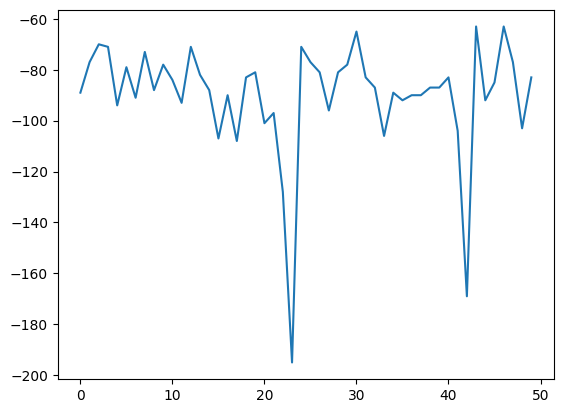


Recompensa de Media: -90.0 



In [92]:
# Evaluamos al Generador 
rewardMean=gan7.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 8 

In [93]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [94]:
longitud_trayectoria += np.count_nonzero(expert_num_tray ==7)
print(longitud_trayectoria)

710


In [95]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [96]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [97]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 568
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 142


In [98]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [99]:
gan8=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [100]:
tf.config.run_functions_eagerly(True)
gan8.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [101]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan8.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.9194736

g_loss= 1.1036308
 1/36 [..............................] - ETA: 5:02:44 - d_loss: 1.9195 - g_loss: 1.1036


d_loss= 1.9219012

g_loss= 1.0495914
 2/36 [>.............................] - ETA: 5:04:19 - d_loss: 1.9207 - g_loss: 1.0766


d_loss= 1.8143291

g_loss= 1.1251256
 3/36 [=>............................] - ETA: 4:49:28 - d_loss: 1.8852 - g_loss: 1.0928


d_loss= 1.9856075

g_loss= 0.60398924
 4/36 [==>...........................] - ETA: 4:40:47 - d_loss: 1.9103 - g_loss: 0.9706


d_loss= 1.8376138

g_loss= 0.57997036
 5/36 [===>..........................] - ETA: 4:31:29 - d_loss: 1.8958 - g_loss: 0.8925


d_loss= 1.914955

g_loss= 0.9835408
 6/36 [====>.........................] - ETA: 4:22:29 - d_loss: 1.8990 - g_loss: 0.9076


d_loss= 1.9143872

g_loss= 1.0706409
 7/36 [====>.........................] - ETA: 4:14:39 - d_loss: 1.9012 - g_loss: 0.9309


d_loss= 1.9904593

g_loss= 0.94077647
 8/36 [=====>........................] - ETA: 4:05:36 - d_loss: 1.912

### Evaluación de GAIL

In [102]:
# Evaluamos el Discriminador de GAIL en el TEST
gan8.evaluate_D(X_test)


1/1 [==============================] - 0s 15ms/step - loss: 9.4264e-04 - accuracy: 0.0000e+00
>Loss real: 
0.0027878587134182453
>Loss fake: 
0.000942641869187355


Episode  0 Total reward: -93.0
Episode  1 Total reward: -72.0
Episode  2 Total reward: -89.0
Episode  3 Total reward: -95.0
Episode  4 Total reward: -167.0
Episode  5 Total reward: -82.0
Episode  6 Total reward: -109.0
Episode  7 Total reward: -73.0
Episode  8 Total reward: -73.0
Episode  9 Total reward: -81.0
Episode  10 Total reward: -79.0
Episode  11 Total reward: -71.0
Episode  12 Total reward: -82.0
Episode  13 Total reward: -82.0
Episode  14 Total reward: -91.0
Episode  15 Total reward: -76.0
Episode  16 Total reward: -90.0
Episode  17 Total reward: -60.0
Episode  18 Total reward: -107.0
Episode  19 Total reward: -83.0
Episode  20 Total reward: -112.0
Episode  21 Total reward: -70.0
Episode  22 Total reward: -87.0
Episode  23 Total reward: -73.0
Episode  24 Total reward: -96.0
Episode  25 Total reward: -78.0
Episode  26 Total reward: -95.0
Episode  27 Total reward: -95.0
Episode  28 Total reward: -75.0
Episode  29 Total reward: -80.0
Episode  30 Total reward: -183.0
Episode  31 T

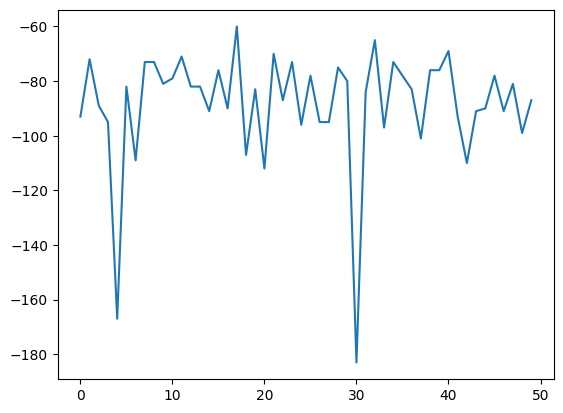


Recompensa de Media: -88.42 



In [103]:
# Evaluamos al Generador 
rewardMean=gan8.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 9

In [104]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [105]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 8)
print(longitud_trayectoria)

820


In [106]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [107]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [108]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 656
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 164


In [109]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [110]:
gan9=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [111]:
tf.config.run_functions_eagerly(True)
gan9.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [112]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan9.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.793168

g_loss= -0.4637427
 1/41 [..............................] - ETA: 6:00:31 - d_loss: 1.7932 - g_loss: -0.4637


d_loss= 1.7852246

g_loss= 0.8122348
 2/41 [>.............................] - ETA: 5:40:21 - d_loss: 1.7892 - g_loss: 0.1742 


d_loss= 1.8939751

g_loss= 0.8968257
 3/41 [=>............................] - ETA: 5:28:54 - d_loss: 1.8241 - g_loss: 0.4151


d_loss= 1.949656

g_loss= 1.2227417
 4/41 [=>............................] - ETA: 5:17:42 - d_loss: 1.8555 - g_loss: 0.6170


d_loss= 1.8444977

g_loss= 0.71924496
 5/41 [==>...........................] - ETA: 5:08:39 - d_loss: 1.8533 - g_loss: 0.6375


d_loss= 1.8165348

g_loss= 1.2111433
 6/41 [===>..........................] - ETA: 5:00:09 - d_loss: 1.8472 - g_loss: 0.7331


d_loss= 1.754149

g_loss= 1.3418232
 7/41 [====>.........................] - ETA: 4:51:53 - d_loss: 1.8339 - g_loss: 0.8200


d_loss= 2.0447183

g_loss= 1.1037549
 8/41 [====>.........................] - ETA: 4:43:25 - d_loss: 1.8602

### Evaluación de GAIL

In [113]:
# Evaluamos el Discriminador de GAIL en el TEST
gan9.evaluate_D(X_test)


1/1 [==============================] - 0s 14ms/step - loss: 0.0016 - accuracy: 0.0000e+00
>Loss real: 
0.0015736700734123588
>Loss fake: 
0.0016366866184398532


Episode  0 Total reward: -71.0
Episode  1 Total reward: -87.0
Episode  2 Total reward: -81.0
Episode  3 Total reward: -88.0
Episode  4 Total reward: -92.0
Episode  5 Total reward: -72.0
Episode  6 Total reward: -119.0
Episode  7 Total reward: -146.0
Episode  8 Total reward: -70.0
Episode  9 Total reward: -81.0
Episode  10 Total reward: -63.0
Episode  11 Total reward: -83.0
Episode  12 Total reward: -86.0
Episode  13 Total reward: -78.0
Episode  14 Total reward: -85.0
Episode  15 Total reward: -187.0
Episode  16 Total reward: -77.0
Episode  17 Total reward: -69.0
Episode  18 Total reward: -166.0
Episode  19 Total reward: -62.0
Episode  20 Total reward: -70.0
Episode  21 Total reward: -76.0
Episode  22 Total reward: -90.0
Episode  23 Total reward: -88.0
Episode  24 Total reward: -90.0
Episode  25 Total reward: -70.0
Episode  26 Total reward: -82.0
Episode  27 Total reward: -73.0
Episode  28 Total reward: -84.0
Episode  29 Total reward: -64.0
Episode  30 Total reward: -94.0
Episode  31 To

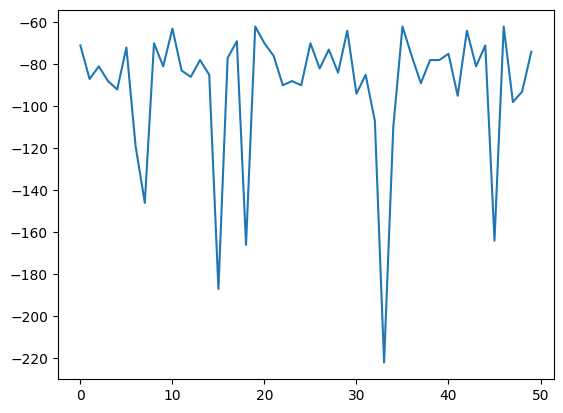


Recompensa de Media: -90.56 



In [114]:
# Evaluamos al Generador 
rewardMean=gan9.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')

## Experimento 10 

In [115]:
expert_observations = np.genfromtxt("observations_Acrobot__.csv",delimiter="\t",dtype=str)
expert_actions = np.genfromtxt('actions_Acrobot__.csv', dtype=np.int32)
expert_next_observations = np.genfromtxt('next_observations_Acrobot__.csv',delimiter="\t",dtype=str)
expert_rewards = np.genfromtxt('rewards_Acrobot__.csv', dtype=np.int32)
expert_num_tray=np.genfromtxt('n_trayectoria_Acrobot__.csv', dtype=np.int32)


# Reemplazar las comas
expert_observations = np.core.defchararray.replace(expert_observations, ',', ' ')

# Reemplazar las comas
expert_next_observations = np.core.defchararray.replace(expert_next_observations, ',', ' ')

# Crear un nuevo array para almacenar los datos convertidos
converted_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)
# Crear un nuevo array para almacenar los datos convertidos
converted_next_observations = np.genfromtxt(expert_observations, delimiter=' ', dtype=float)


rewards=np.array(expert_rewards).reshape(-1,1)


print("\n\tEstados reales: \n", converted_observations)
print("\tAcciones reales: \n", expert_actions)
print("\n\t Estados siguientes: \n", converted_next_observations)
print("\n\t Recompensas:" ,expert_rewards)


	Estados reales: 
 [[ 9.9979950e-01 -2.0024860e-02  9.9997770e-01  6.6733644e-03
   9.6756910e-02 -8.8986360e-02]
 [ 9.9992436e-01 -1.2298712e-02  9.9976075e-01  2.1873672e-02
  -2.0382820e-02  2.3919060e-01]
 [ 9.9962884e-01 -2.7242111e-02  9.9512610e-01  9.8610340e-02
  -1.2337531e-01  5.1367980e-01]
 ...
 [ 9.4503516e-01  3.2696870e-01 -3.9711353e-01 -9.1776950e-01
   4.4456690e+00 -6.7818550e+00]
 [ 3.9513140e-01  9.1862464e-01 -9.9999440e-01 -3.3479250e-03
   3.7521253e+00 -5.0126970e+00]
 [-2.2371536e-01  9.7465450e-01 -6.2530230e-01  7.8038260e-01
   2.5568993e+00 -4.0255790e+00]]
	Acciones reales: 
 [2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2
 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 0 0
 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0 0 0 0 2 2 2 2 2 2 0 0 0
 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [116]:
longitud_trayectoria += np.count_nonzero(expert_num_tray == 9)
print(longitud_trayectoria)

892


In [117]:
# Nos quedamos solo con la primera trayectoria
converted_observations=converted_observations[0:longitud_trayectoria]
expert_actions=expert_actions[0:longitud_trayectoria]
converted_next_observations=converted_next_observations[0:longitud_trayectoria]
expert_rewards=expert_rewards[0:longitud_trayectoria]

In [118]:
# Construimos el dataset [s,a,s',r] reales y lo dividimos en training y test
expert_a_one_hot=np.eye(env.action_space.n)[expert_actions]
expert_rewards = expert_rewards.reshape(-1, 1)

dataset1=np.concatenate([converted_observations,expert_a_one_hot],axis=1)
dataset2=np.concatenate([dataset1,converted_next_observations],axis=1)
dataset=np.concatenate([dataset2,expert_rewards],axis=1)


In [119]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


#Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))


Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 713
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 179


In [120]:
env= gym.make('Acrobot-v1')
obs,_= env.reset()

# Generador
generator=Policy_net( 'policy', env, obs)

# Generamos [s,a, s', r] falsas y las políticas theta_i y theta_i+1
observations, actions, next_observations, rewards, Old_Policy, Policy=generator.generate_fakes()

# Discriminador
discriminator=Discriminator(env, discriminator_net, converted_observations, expert_actions, converted_next_observations, expert_rewards, observations, actions, next_observations, rewards)

### Definición de GAIL

In [121]:
gan10=GAN(discriminator=discriminator,generator=generator)

### Compilación de GAIL

In [122]:
tf.config.run_functions_eagerly(True)
gan10.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de GAIL

In [123]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

history=gan10.fit(X_train,
    epochs=EPOCHS, batch_size=BATCH_SIZE)






d_loss= 1.9228961

g_loss= 0.94633645
 1/45 [..............................] - ETA: 6:22:00 - d_loss: 1.9229 - g_loss: 0.9463


d_loss= 1.9272505

g_loss= 1.0564849
 2/45 [>.............................] - ETA: 6:25:12 - d_loss: 1.9251 - g_loss: 1.0014


d_loss= 1.9943662

g_loss= 0.92907697
 3/45 [=>............................] - ETA: 6:08:30 - d_loss: 1.9482 - g_loss: 0.9773


d_loss= 1.7828646

g_loss= 1.3060325
 4/45 [=>............................] - ETA: 5:58:29 - d_loss: 1.9068 - g_loss: 1.0595


d_loss= 1.8507949

g_loss= 0.75321794
 5/45 [==>...........................] - ETA: 5:47:45 - d_loss: 1.8956 - g_loss: 0.9982


d_loss= 1.9562606

g_loss= 0.6759672
 6/45 [===>..........................] - ETA: 5:38:24 - d_loss: 1.9057 - g_loss: 0.9445


d_loss= 1.9096423

g_loss= 0.8754816
 7/45 [===>..........................] - ETA: 5:28:28 - d_loss: 1.9063 - g_loss: 0.9347


d_loss= 1.9202542

g_loss= 1.2576526
 8/45 [====>.........................] - ETA: 5:20:23 - d_loss: 1.90

### Evaluación de GAIL

In [124]:
# Evaluamos el Discriminador de GAIL en el TEST
gan10.evaluate_D(X_test)


1/1 [==============================] - 0s 20ms/step - loss: 0.0017 - accuracy: 0.0000e+00
>Loss real: 
0.000160468349349685
>Loss fake: 
0.001734594814479351


Episode  0 Total reward: -500.0
Episode  1 Total reward: -71.0
Episode  2 Total reward: -93.0
Episode  3 Total reward: -106.0
Episode  4 Total reward: -84.0
Episode  5 Total reward: -76.0
Episode  6 Total reward: -142.0
Episode  7 Total reward: -96.0
Episode  8 Total reward: -160.0
Episode  9 Total reward: -104.0
Episode  10 Total reward: -70.0
Episode  11 Total reward: -101.0
Episode  12 Total reward: -132.0
Episode  13 Total reward: -81.0
Episode  14 Total reward: -98.0
Episode  15 Total reward: -80.0
Episode  16 Total reward: -80.0
Episode  17 Total reward: -76.0
Episode  18 Total reward: -159.0
Episode  19 Total reward: -103.0
Episode  20 Total reward: -79.0
Episode  21 Total reward: -72.0
Episode  22 Total reward: -64.0
Episode  23 Total reward: -94.0
Episode  24 Total reward: -70.0
Episode  25 Total reward: -77.0
Episode  26 Total reward: -75.0
Episode  27 Total reward: -98.0
Episode  28 Total reward: -75.0
Episode  29 Total reward: -75.0
Episode  30 Total reward: -88.0
Episode  

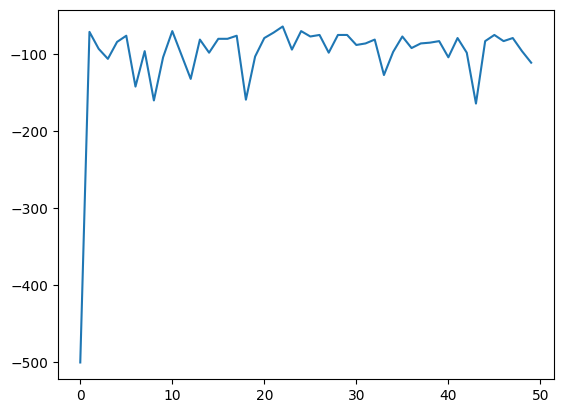


Recompensa de Media: -101.3 



In [125]:
# Evaluamos al Generador 
rewardMean=gan10.evaluate_G()
print('\nRecompensa de Media:', rewardMean, '\n')